## Quick Start for Expert 

- https://www.tensorflow.org/tutorials/quickstart/advanced

In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

import matplotlib.pyplot as plt


2024-05-30 04:27:49.996312: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.16.1


In [2]:
# List all available physical devices (CPUs and GPUs)
physical_devices = tf.config.list_physical_devices()
print("Available physical devices:", physical_devices)

Available physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


2024-05-30 04:27:51.064488: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-30 04:27:51.064702: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-30 04:27:51.069508: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

> The warning could be related to some compatible issues of cuda, linux kernel, or tensorflow versions,
> <br> but this does not seem to be critical.

In [3]:
import warnings
warnings.filterwarnings("ignore", category=ResourceWarning)  # Example: Ignore resource warnings
tf.get_logger().setLevel('ERROR')  # Set logging level to only show errors

In [4]:
# Check if GPUs are available
gpus_available = tf.config.list_physical_devices('GPU')
if gpus_available:
    print("GPUs are available. TensorFlow is configured to use GPU.")
else:
    print("No GPUs are available. TensorFlow is likely configured to use CPU.")

GPUs are available. TensorFlow is configured to use GPU.


In [5]:
tf.keras.backend.backend()

'tensorflow'

### Load MNIST dataset

In [6]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

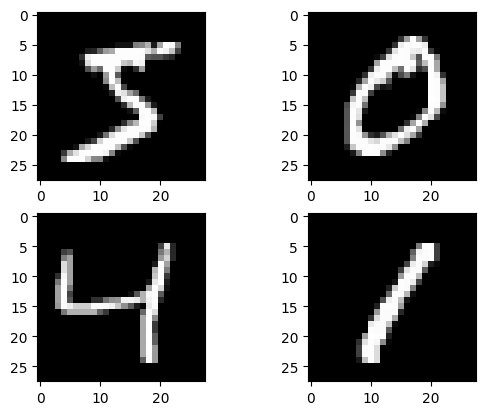

In [7]:
# plot 4 images as gray scale
plt.subplot(221)
plt.imshow(x_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(x_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(x_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(x_train[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

### Batch and Shuffle Dataset

In [8]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

2024-05-30 04:27:52.128079: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-30 04:27:52.128262: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-30 04:27:52.128420: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

### Defining DL Model 

In [9]:
class MyModel(Model):
  def __init__(self):
    super().__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10)

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

In [10]:
# Create an instance of the model
model = MyModel()

### Optimizer and Loss Function

In [11]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [12]:
optimizer = tf.keras.optimizers.Adam()

### Metrics for Training

In [13]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

### Train the Model 

In [14]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [15]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [16]:
EPOCHS = 5

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_state()
  train_accuracy.reset_state()
  test_loss.reset_state()
  test_accuracy.reset_state()

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result():0.2f}, '
    f'Accuracy: {train_accuracy.result() * 100:0.2f}, '
    f'Test Loss: {test_loss.result():0.2f}, '
    f'Test Accuracy: {test_accuracy.result() * 100:0.2f}'
  )

2024-05-30 04:27:55.568768: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
2024-05-30 04:27:58.718003: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-30 04:27:59.181891: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1, Loss: 0.14, Accuracy: 95.92, Test Loss: 0.06, Test Accuracy: 97.73


2024-05-30 04:28:02.099714: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-30 04:28:02.276809: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2, Loss: 0.04, Accuracy: 98.66, Test Loss: 0.06, Test Accuracy: 98.21


2024-05-30 04:28:05.298402: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-30 04:28:05.528683: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 3, Loss: 0.02, Accuracy: 99.19, Test Loss: 0.06, Test Accuracy: 98.33


2024-05-30 04:28:08.460992: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-30 04:28:08.689763: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4, Loss: 0.01, Accuracy: 99.51, Test Loss: 0.06, Test Accuracy: 98.05
Epoch 5, Loss: 0.01, Accuracy: 99.71, Test Loss: 0.06, Test Accuracy: 98.53


2024-05-30 04:28:11.274757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-30 04:28:11.450637: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Visualize the history of training 

In [17]:
%%time
# Initialize lists to store learning history
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

EPOCHS = 5

for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_state()
    train_accuracy.reset_state()
    test_loss.reset_state()
    test_accuracy.reset_state()

    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    # Store the current metrics in the history lists
    train_losses.append(train_loss.result().numpy())
    train_accuracies.append(train_accuracy.result().numpy())
    test_losses.append(test_loss.result().numpy())
    test_accuracies.append(test_accuracy.result().numpy())

    print(
        f'Epoch {epoch + 1}, '
        f'Loss: {train_loss.result():0.2f}, '
        f'Accuracy: {train_accuracy.result() * 100:0.2f}, '
        f'Test Loss: {test_loss.result():0.2f}, '
        f'Test Accuracy: {test_accuracy.result() * 100:0.2f}'
    )


2024-05-30 04:28:14.199164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-30 04:28:14.375406: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1, Loss: 0.01, Accuracy: 99.73, Test Loss: 0.06, Test Accuracy: 98.39


2024-05-30 04:28:17.158646: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-30 04:28:17.382311: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2, Loss: 0.01, Accuracy: 99.78, Test Loss: 0.06, Test Accuracy: 98.62


2024-05-30 04:28:20.372189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-30 04:28:20.548774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 3, Loss: 0.00, Accuracy: 99.86, Test Loss: 0.07, Test Accuracy: 98.47


2024-05-30 04:28:22.950466: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-30 04:28:23.124695: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4, Loss: 0.00, Accuracy: 99.89, Test Loss: 0.08, Test Accuracy: 98.46
Epoch 5, Loss: 0.01, Accuracy: 99.81, Test Loss: 0.08, Test Accuracy: 98.39
CPU times: user 18.6 s, sys: 1.66 s, total: 20.3 s
Wall time: 14.8 s


2024-05-30 04:28:26.117733: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-30 04:28:26.292639: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


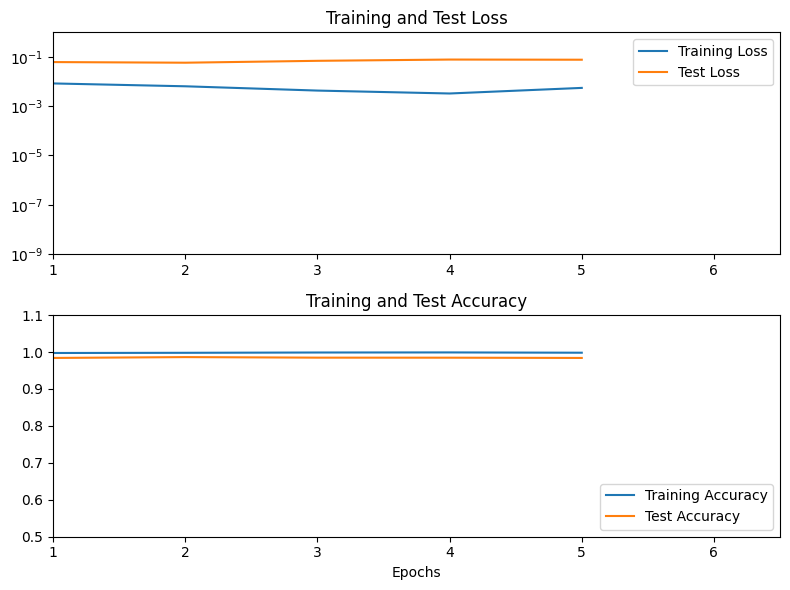

In [18]:
# Visualize the learning history
epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(8, 6))

# Plot training and test loss
plt.subplot(2, 1, 1)
plt.axis([1,6.5,0.000000001,1.0])
plt.yscale('log')
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, test_losses, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training and Test Loss')

# Plot training and test accuracy
plt.subplot(2, 1, 2)
plt.axis([1,6.5,0.5,1.1])
#plt.yscale('log')
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, test_accuracies, label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Test Accuracy')

plt.xlabel('Epochs')
plt.tight_layout()
plt.show()